$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $

<h1>Optimizing the number of qubits and control gates</h1>

Here we implement small experiment that could be considered for currently available real quantum devices. We have a complete binary tree with two layers (root, two childrean and four leaves). In this implementation we use three qubits.

In this implementation, we use different encoding to ensure that Hamming distance between parent and children basis states is at most two.

Root is $\ket{000}$, first child is $\ket{010}$, second child is $\ket{011}$. Children of $\ket{010}$ are $\ket{100}$ and $\ket{110}$; children of $\ket{011}$ are $\ket{101}$ and $\ket{111}$.

We use the approach that does not use Phase estimation, like in the notebook "Detecting a marked vertex - solution without phase estimation".

In [1]:
num_of_layers = 2 #fixed
bits_of_precision = 1

<h3>Root: 000 to 010 and 011</h3>

In [2]:
psi = {}

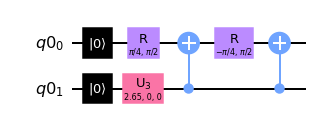

In [3]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from math import pi, sqrt
qc = QuantumCircuit(3)

desired_vector = [
    1/sqrt(1+2*(num_of_layers*4)), # 00
    0, # 01
    sqrt(num_of_layers*4)/sqrt(1+2*(num_of_layers*4)), # 10
    sqrt(num_of_layers*4)/sqrt(1+2*(num_of_layers*4)) #11
]

q = QuantumRegister(2)
qc = QuantumCircuit(q)

qc.initialize(desired_vector, [q[0],q[1]])
qc2 = qc.decompose().decompose().decompose().decompose().decompose()

qc2.draw(output='mpl')

<ipython-input-4-891040848c65>:2: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  psi['000'].u3(pi/4,0,0,0)


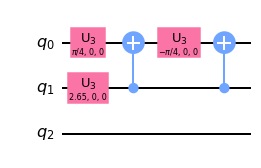

In [4]:
psi['000'] = QuantumCircuit(num_of_layers+1)
psi['000'].u3(pi/4,0,0,0)
psi['000'].u3(2.65,0,0,1)
psi['000'].cx(1,0)
psi['000'].u3(-pi/4,0,0,0)
psi['000'].cx(1,0)

psi['000'].draw(output='mpl')

<h3>Parent 1: 010 to 100 and 110</h3>

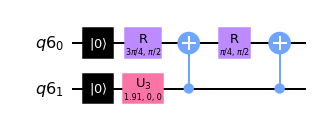

In [5]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from math import pi, sqrt
qc = QuantumCircuit(3)

desired_vector = [
    0, # 00
    1/sqrt(3), # 01
    1/sqrt(3), # 10
    1/sqrt(3) #11
]

q = QuantumRegister(2)
qc = QuantumCircuit(q)

qc.initialize(desired_vector, [q[0],q[1]])
qc2 = qc.decompose().decompose().decompose().decompose().decompose()

qc2.draw(output='mpl')

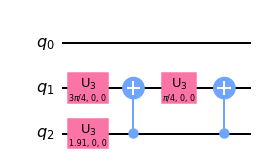

In [6]:
psi['010'] = QuantumCircuit(num_of_layers+1)
psi['010'].u3(3*pi/4,0,0,1)
psi['010'].u3(1.91,0,0,2)
psi['010'].cx(2,1)
psi['010'].u3(pi/4,0,0,1)
psi['010'].cx(2,1)

psi['010'].draw(output='mpl')

<h3>Parent 2: 011 to 101 and 111</h3>

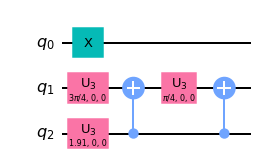

In [7]:
psi['011'] = QuantumCircuit(num_of_layers+1)
psi['011'].u3(3*pi/4,0,0,1)
psi['011'].u3(1.91,0,0,2)
psi['011'].cx(2,1)
psi['011'].u3(pi/4,0,0,1)
psi['011'].cx(2,1)
psi['011'].x(0)

psi['011'].draw(output='mpl')

<h3>Leaves: 100  110  101  111</h3>

In [8]:
psi['100'] = QuantumCircuit(num_of_layers+1)
psi['100'].x(2)

psi['110'] = QuantumCircuit(num_of_layers+1)
psi['110'].x(2)
psi['110'].x(1)

psi['101'] = QuantumCircuit(num_of_layers+1)
psi['101'].x(2)
psi['101'].x(0)

psi['111'] = QuantumCircuit(num_of_layers+1)
psi['111'].x(2)
psi['111'].x(1)
psi['111'].x(0)

<h3>Operators</h3>

In [9]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from math import pi

identity_minus_state_zero = QuantumCircuit(num_of_layers+1)

for i in range(num_of_layers+1):
    identity_minus_state_zero.x(i)

control_states = []
for i in range(num_of_layers+1):
    control_states.append(i)


identity_minus_state_zero.h(num_of_layers)
identity_minus_state_zero.ccx(0,1,2)
identity_minus_state_zero.h(num_of_layers)

for i in range(num_of_layers+1):
    identity_minus_state_zero.x(i)

d={}
for i in ['000','010','011','100','110','101','111']: 
    d[i] = QuantumCircuit(num_of_layers+1)
    d[i] = d[i].compose(psi[i].inverse(),control_states)
    d[i] = d[i].compose(identity_minus_state_zero)
    d[i] = d[i].compose(psi[i],control_states)

<h2>Implementation</h2>

In [10]:
marked=[]

marked: [], outcome: 
experiment: 0
100.0 %
experiment: 1
78.09 %


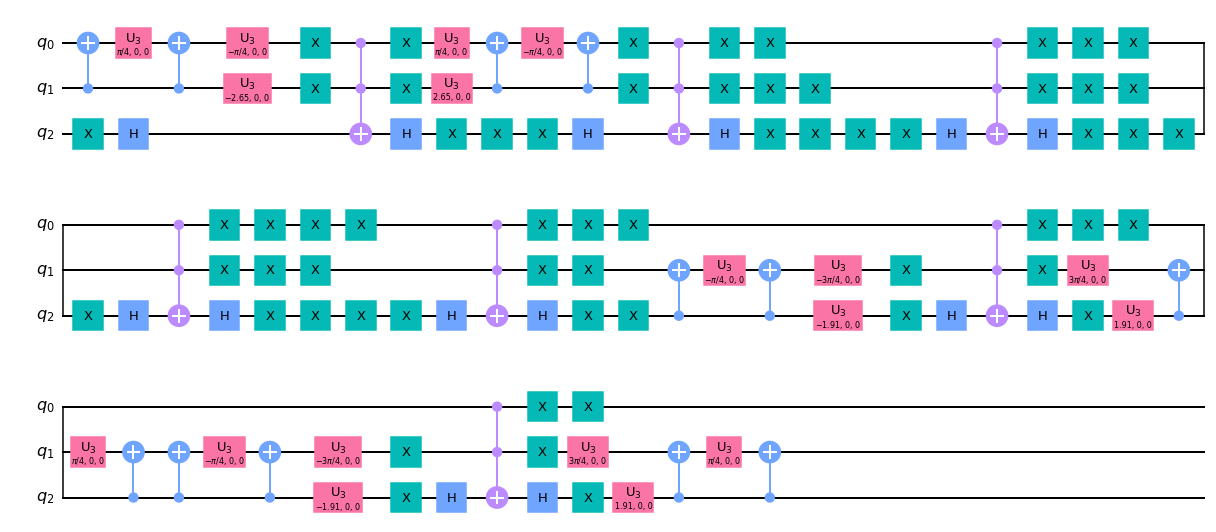

In [11]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from math import pi
from qiskit.circuit.library import QFT
from datetime import datetime
import time

r_a = QuantumCircuit(num_of_layers+1)

# root
r_a = r_a.compose(d['000'])


for i in ['100','110','101','111']:
    if not i in marked:
        r_a = r_a.compose(d[i])
    
r_b = QuantumCircuit(num_of_layers+1)

for i in ['010','011']:
    if not i in marked:
        r_b = r_b.compose(d[i])

rbra = r_a
rbra = rbra.compose(r_b)

print('marked: ['+', '.join(marked)+'], outcome: ')
n = ''
n = n.zfill(num_of_layers+1)

composed_rbra = QuantumCircuit(num_of_layers+1)
summation = 0
for experiment in range(2**bits_of_precision):
    circuit = QuantumCircuit(num_of_layers+1,num_of_layers+1)
    circuit = circuit.compose(composed_rbra)
    circuit.measure(range(num_of_layers+1),range(num_of_layers+1))
    job = execute(circuit,Aer.get_backend('qasm_simulator'),shots=10000)
    counts = job.result().get_counts(circuit)
    result = counts.get(n, 0)
    print('experiment:',experiment)
    print(result/100,'%')
    summation += result
    composed_rbra = composed_rbra.compose(rbra)
rbra.draw(output='mpl')

Here we do not optimize single-qubit gates. It is possible to manually remove redundant X-gates before launching the circuit on a quantum computer. The generated example is a single $R_BR_A$ transformation.